# Road Traffic Accident Analysis

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Data Loading

In [6]:
df = pd.read_excel('RTA Dataset_with_DD.xlsx')

print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {len(df.columns)}")
df.head()

Dataset shape: (12316, 32)

Columns: 32


,Time,Day_of_week,Age_band_of_driver,Sex_of_driver,Educational_level,Vehicle_driver_relation,Driving_experience,Type_of_vehicle,Owner_of_vehicle,Service_year_of_vehicle,...,Vehicle_movement,Casualty_class,Sex_of_casualty,Age_band_of_casualty,Casualty_severity,Work_of_casuality,Fitness_of_casuality,Pedestrian_movement,Cause_of_accident,Accident_severity
0,17:02:00,Monday,18-30,Male,Above high school,Employee,1-2yr,Automobile,Owner,Above 10yr,...,Going straight,na,na,na,na,NaN,NaN,Not a Pedestrian,Moving Backward,Slight Injury
1,17:02:00,Monday,31-50,Male,Junior high school,Employee,Above 10yr,Public (> 45 seats),Owner,5-10yrs,...,Going straight,na,na,na,na,NaN,NaN,Not a Pedestrian,Overtaking,Slight Injury
2,17:02:00,Monday,18-30,Male,Junior high school,Employee,1-2yr,Lorry (41?100Q),Owner,NaN,...,Going straight,Driver or rider,Male,31-50,3,Driver,NaN,Not a Pedestrian,Changing lane to the left,Serious Injury
3,01:06:00,Sunday,18-30,Male,Junior high school,Employee,5-10yr,Public (> 45 seats),Governmental,NaN,...,Going straight,Pedestrian,Female,18-30,3,Driver,Normal,Not a Pedestrian,Changing lane to the right,Slight Injury
4,01:06:00,Sunday,18-30,Male,Junior high school,Employee,2-5yr,NaN,Owner,5-10yrs,...,Going straight,na,na,na,na,NaN,NaN,Not a Pedestrian,Overtaking,Slight Injury


## 2. Data Cleaning & Preprocessing

### Missing Values Analysis

Missing Values Summary:
                         Missing_Count  Percentage
Defect_of_vehicle                 4427   35.945112
Service_year_of_vehicle           3928   31.893472
Work_of_casuality                 3198   25.966223
Fitness_of_casuality              2635   21.394933
Type_of_vehicle                    950    7.713543
Types_of_Junction                  887    7.202014
Driving_experience                 829    6.731082
Educational_level                  741    6.016564
Vehicle_driver_relation            579    4.701202
Owner_of_vehicle                   482    3.913608
Lanes_or_Medians                   385    3.126015
Vehicle_movement                   308    2.500812
Area_accident_occured              239    1.940565
Road_surface_type                  172    1.396557
Type_of_collision                  155    1.258525
Road_allignment                    142    1.152972


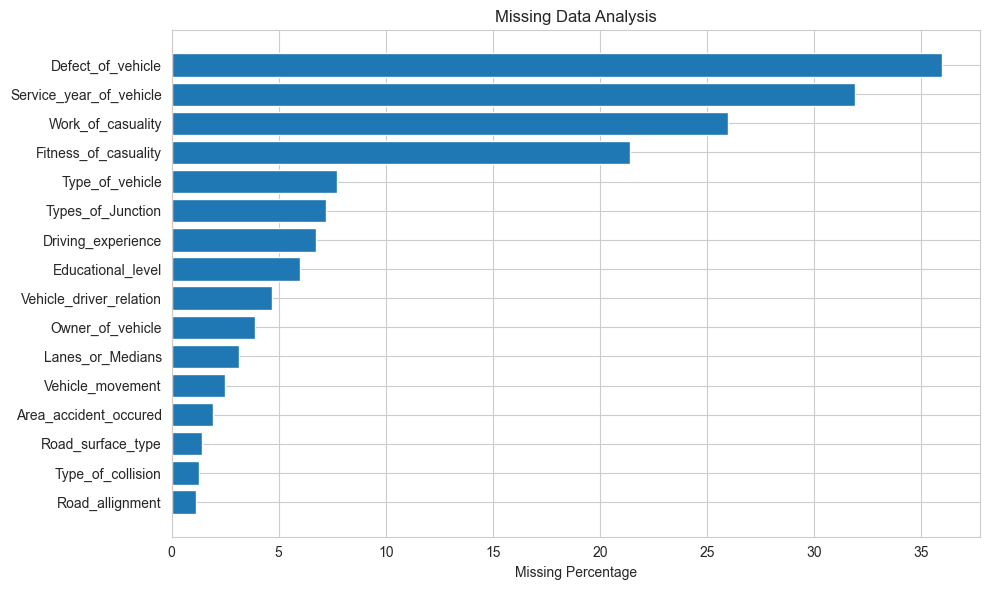

In [7]:
missing = df.isnull().sum()
missing_pct = (df.isnull().sum() / len(df)) * 100

missing_df = pd.DataFrame({
    'Missing_Count': missing,
    'Percentage': missing_pct
}).sort_values('Percentage', ascending=False)

print("Missing Values Summary:")
print(missing_df[missing_df['Missing_Count'] > 0])

plt.figure(figsize=(10, 6))
missing_data = missing_df[missing_df['Missing_Count'] > 0].sort_values('Percentage')
plt.barh(missing_data.index, missing_data['Percentage'])
plt.xlabel('Missing Percentage')
plt.title('Missing Data Analysis')
plt.tight_layout()
plt.show()

### Remove Redundant/Incomplete Columns

In [8]:
columns_to_drop = [
    'Defect_of_vehicle',
    'Service_year_of_vehicle',
    'Fitness_of_casuality',
    'Pedestrian_movement',
    'Casualty_severity'
]

df = df.drop(columns=columns_to_drop)
print(f"\nRemoved {len(columns_to_drop)} columns")
print(f"New shape: {df.shape}")


Removed 5 columns
New shape: (12316, 27)


### Handle Missing Values - Mode Imputation

In [9]:
df['Educational_level'].fillna(df['Educational_level'].mode()[0], inplace=True)
df['Vehicle_driver_relation'].fillna('Employee', inplace=True)
df['Owner_of_vehicle'].fillna('Owner', inplace=True)
df['Road_surface_type'].fillna('Asphalt roads', inplace=True)
df['Road_allignment'].fillna('Tangent road with flat terrain', inplace=True)

### Handle Missing Values - Conditional Imputation

In [10]:
def impute_vehicle_type(row):
    if pd.isna(row['Type_of_vehicle']):
        if row['Type_of_collision'] == 'Collision with pedestrians':
            return 'Automobile'
        elif row['Type_of_collision'] == 'Rollover':
            return 'Automobile'
        else:
            return 'Automobile'
    return row['Type_of_vehicle']

df['Type_of_vehicle'] = df.apply(impute_vehicle_type, axis=1)

def impute_junction(row):
    if pd.isna(row['Types_of_Junction']):
        if 'Tangent road with flat terrain' in str(row['Road_allignment']):
            return 'No junction'
        else:
            return 'Y Shape'
    return row['Types_of_Junction']

df['Types_of_Junction'] = df.apply(impute_junction, axis=1)

def impute_experience(row):
    if pd.isna(row['Driving_experience']):
        age = row['Age_band_of_driver']
        if age in ['18-30', 'Under 18']:
            return '2-5yr'
        elif age in ['31-50']:
            return '5-10yr'
        elif age in ['Over 51']:
            return 'Above 10yr'
        else:
            return '5-10yr'
    return row['Driving_experience']

df['Driving_experience'] = df.apply(impute_experience, axis=1)

def impute_area(row):
    if pd.isna(row['Area_accident_occured']):
        try:
            time = row['Time']
            if pd.notna(time):
                hour = int(str(time).split(':')[0])
                if 7 <= hour < 9:
                    return 'Office areas'
                elif 17 <= hour < 19:
                    return 'Residential areas'
                elif hour >= 22 or hour < 5:
                    return 'Residential areas'
                else:
                    return 'Office areas'
        except:
            pass
        return 'Other'
    return row['Area_accident_occured']

df['Area_accident_occured'] = df.apply(impute_area, axis=1)

def impute_lanes(row):
    if pd.isna(row['Lanes_or_Medians']):
        area = row['Area_accident_occured']
        if area in ['Office areas', 'Industrial areas']:
            return 'Two-way (divided with broken lines road marking)'
        else:
            return 'Undivided Two way'
    return row['Lanes_or_Medians']

df['Lanes_or_Medians'] = df.apply(impute_lanes, axis=1)

def impute_movement(row):
    if pd.isna(row['Vehicle_movement']):
        cause = str(row['Cause_of_accident'])
        if 'Backward' in cause:
            return 'Moving Backward'
        elif 'Overtaking' in cause:
            return 'Overtaking'
        else:
            return 'Going straight'
    return row['Vehicle_movement']

df['Vehicle_movement'] = df.apply(impute_movement, axis=1)

def impute_collision_type(row):
    if pd.isna(row['Type_of_collision']):
        cause = str(row['Cause_of_accident'])
        casualties = str(row['Casualty_class'])
        if 'Pedestrian' in casualties:
            return 'Collision with pedestrians'
        elif any(word in cause for word in ['Overtaking', 'lane', 'distancing']):
            return 'Vehicle with vehicle collision'
        else:
            return 'Vehicle with vehicle collision'
    return row['Type_of_collision']

df['Type_of_collision'] = df.apply(impute_collision_type, axis=1)

df['Work_of_casuality'].fillna('Unknown', inplace=True)

print("\nMissing values after cleaning:")
print(df.isnull().sum().sum())


Missing values after cleaning:
0


### Data Standardization

In [11]:
df['Time'] = pd.to_datetime(df['Time'], format='%H:%M:%S', errors='coerce').dt.time

print("\nData types:")
print(df.dtypes)
print("\nData cleaning completed!")


Data types:
Time                           object
Day_of_week                    object
Age_band_of_driver             object
Sex_of_driver                  object
Educational_level              object
Vehicle_driver_relation        object
Driving_experience             object
Type_of_vehicle                object
Owner_of_vehicle               object
Area_accident_occured          object
Lanes_or_Medians               object
Road_allignment                object
Types_of_Junction              object
Road_surface_type              object
Road_surface_conditions        object
Light_conditions               object
Weather_conditions             object
Type_of_collision              object
Number_of_vehicles_involved     int64
Number_of_casualties            int64
Vehicle_movement               object
Casualty_class                 object
Sex_of_casualty                object
Age_band_of_casualty           object
Work_of_casuality              object
Cause_of_accident              object

## 3. Exploratory Data Analysis

### Accident Frequency Analysis - Time Distribution

### Accident Distribution by Day of Week
Day_of_week
Friday       2041
Thursday     1851
Wednesday    1840
Tuesday      1770
Monday       1681
Saturday     1666
Sunday       1467
Name: count, dtype: int64


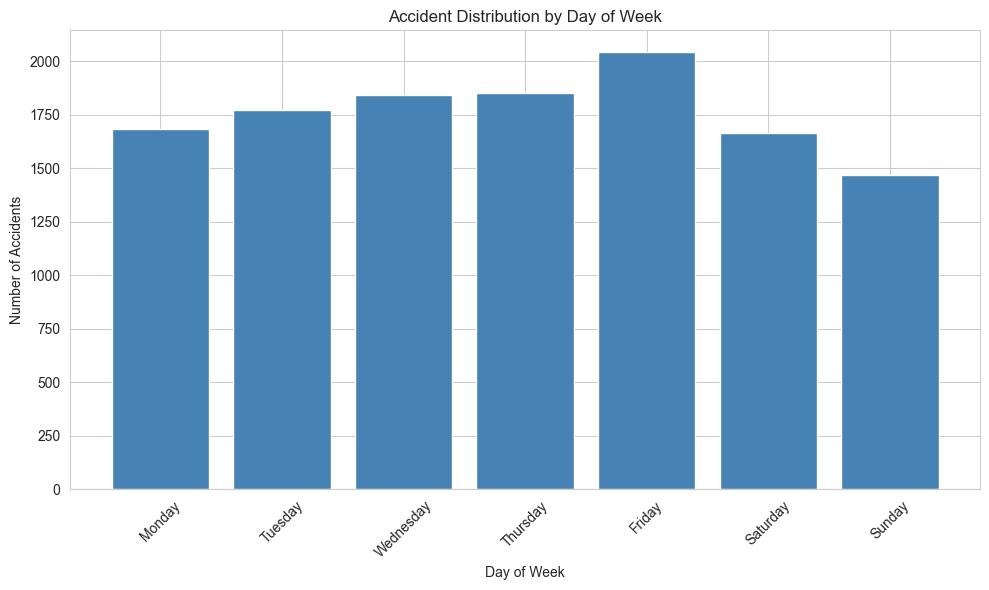

In [12]:
print("### Accident Distribution by Day of Week")
day_counts = df['Day_of_week'].value_counts()
print(day_counts)

plt.figure(figsize=(10, 6))
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_data = df['Day_of_week'].value_counts().reindex(day_order)
plt.bar(day_data.index, day_data.values, color='steelblue')
plt.xlabel('Day of Week')
plt.ylabel('Number of Accidents')
plt.title('Accident Distribution by Day of Week')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Accident Distribution by Hour


### Accident Distribution by Hour
Hour
0    206
1    134
2     84
3     84
4     91
5     76
6    214
7    532
8    828
9    559
Name: count, dtype: int64


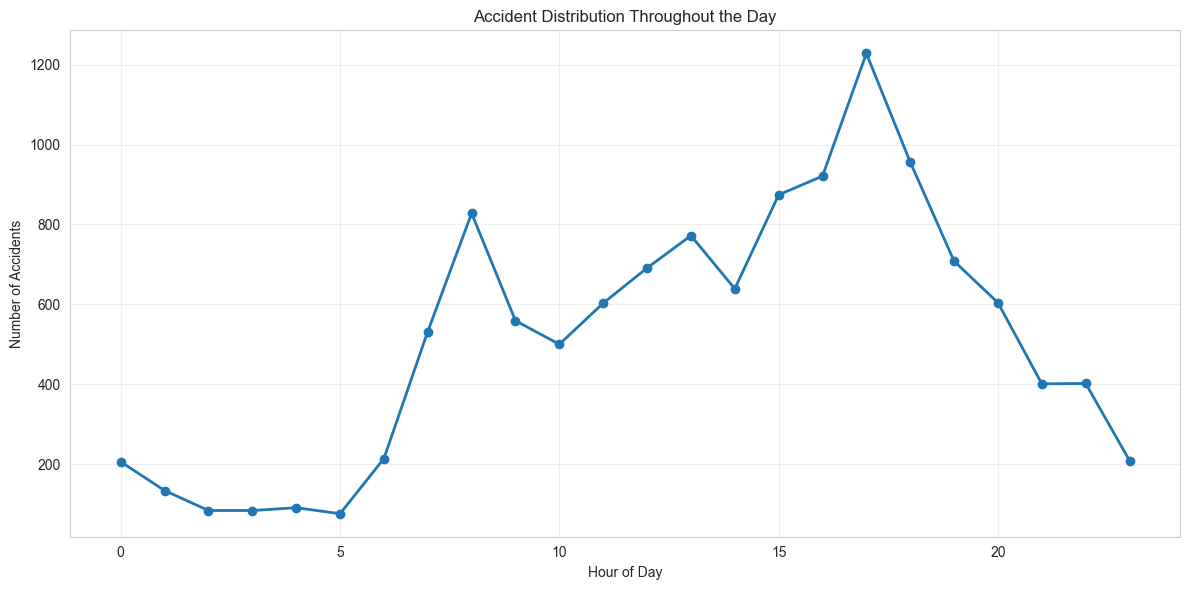

In [13]:
df['Hour'] = df['Time'].apply(lambda x: int(str(x).split(':')[0]) if pd.notna(x) else None)

print("\n### Accident Distribution by Hour")
hour_counts = df['Hour'].value_counts().sort_index()
print(hour_counts.head(10))

plt.figure(figsize=(12, 6))
plt.plot(hour_counts.index, hour_counts.values, marker='o', linewidth=2)
plt.xlabel('Hour of Day')
plt.ylabel('Number of Accidents')
plt.title('Accident Distribution Throughout the Day')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Demographic Insights - Driver Age Analysis

### Driver Age Band Distribution
Age_band_of_driver
18-30       4271
31-50       4087
Over 51     1585
Unknown     1548
Under 18     825
Name: count, dtype: int64


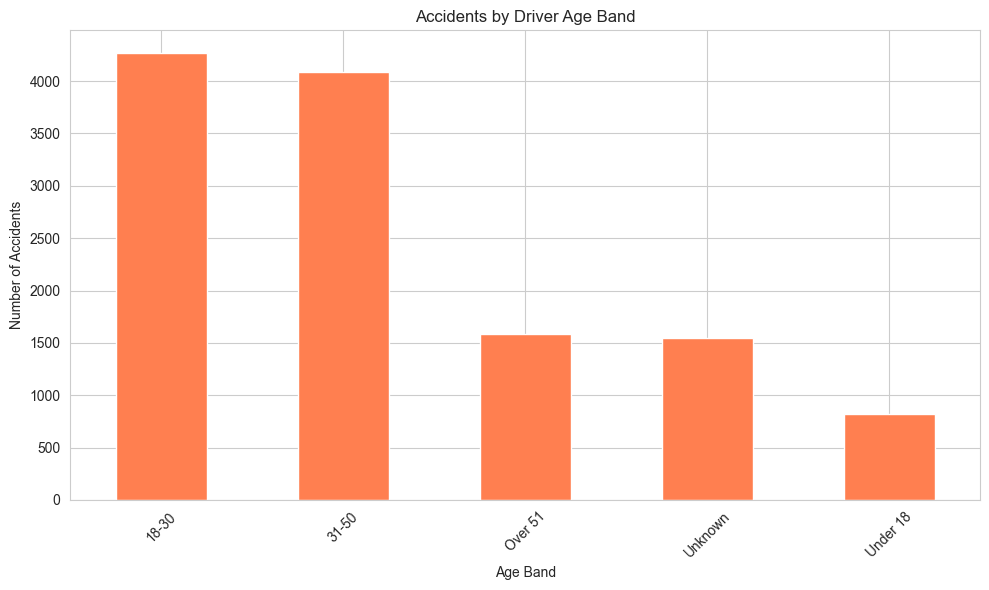

In [14]:
print("### Driver Age Band Distribution")
age_counts = df['Age_band_of_driver'].value_counts()
print(age_counts)

plt.figure(figsize=(10, 6))
age_counts.plot(kind='bar', color='coral')
plt.xlabel('Age Band')
plt.ylabel('Number of Accidents')
plt.title('Accidents by Driver Age Band')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Driver Experience Analysis


### Driving Experience Distribution
Driving_experience
5-10yr        3726
2-5yr         2962
Above 10yr    2379
1-2yr         1756
Below 1yr     1342
No Licence     118
unknown         33
Name: count, dtype: int64


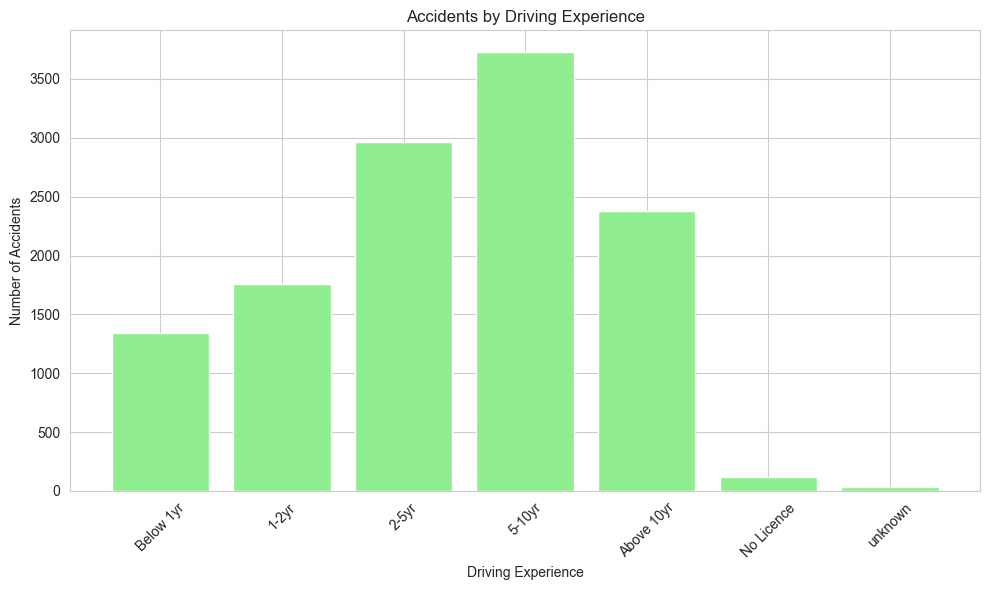

In [15]:
print("\n### Driving Experience Distribution")
exp_counts = df['Driving_experience'].value_counts()
print(exp_counts)

plt.figure(figsize=(10, 6))
exp_order = ['Below 1yr', '1-2yr', '2-5yr', '5-10yr', 'Above 10yr', 'No Licence', 'unknown']
exp_data = df['Driving_experience'].value_counts().reindex([x for x in exp_order if x in exp_counts.index])
plt.bar(exp_data.index, exp_data.values, color='lightgreen')
plt.xlabel('Driving Experience')
plt.ylabel('Number of Accidents')
plt.title('Accidents by Driving Experience')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Gender Distribution


### Gender Distribution
Sex_of_driver
Male       11437
Female       701
Unknown      178
Name: count, dtype: int64


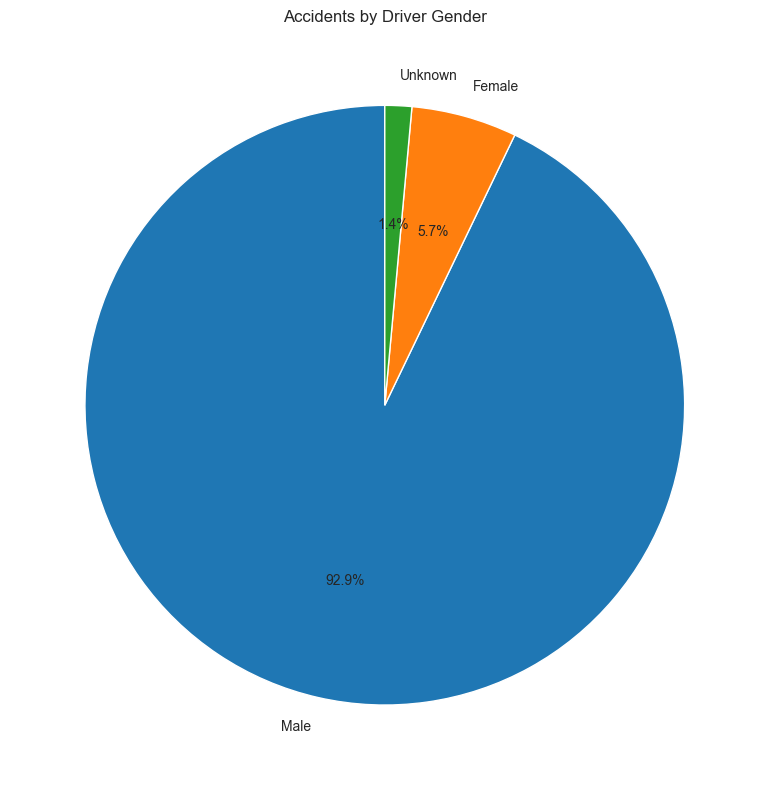

In [16]:
print("\n### Gender Distribution")
gender_counts = df['Sex_of_driver'].value_counts()
print(gender_counts)

plt.figure(figsize=(8, 8))
plt.pie(gender_counts.values, labels=gender_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Accidents by Driver Gender')
plt.tight_layout()
plt.show()

### Educational Level Analysis


### Educational Level Distribution
Educational_level
Junior high school    8360
Elementary school     2163
High school           1110
Above high school      362
Writing & reading      176
Unknown                100
Illiterate              45
Name: count, dtype: int64


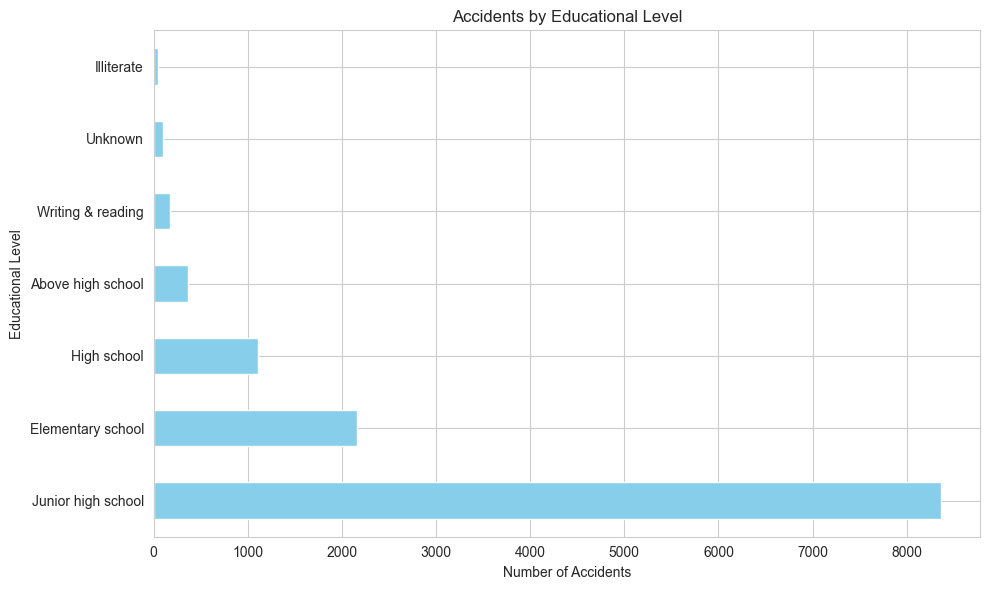

In [17]:
print("\n### Educational Level Distribution")
edu_counts = df['Educational_level'].value_counts()
print(edu_counts)

plt.figure(figsize=(10, 6))
edu_counts.plot(kind='barh', color='skyblue')
plt.xlabel('Number of Accidents')
plt.ylabel('Educational Level')
plt.title('Accidents by Educational Level')
plt.tight_layout()
plt.show()

### Environmental Factors Analysis

### Weather Conditions Impact
Weather_conditions
Normal               10063
Raining               1331
Other                  296
Unknown                292
Cloudy                 125
Windy                   98
Snow                    61
Raining and Windy       40
Fog or mist             10
Name: count, dtype: int64


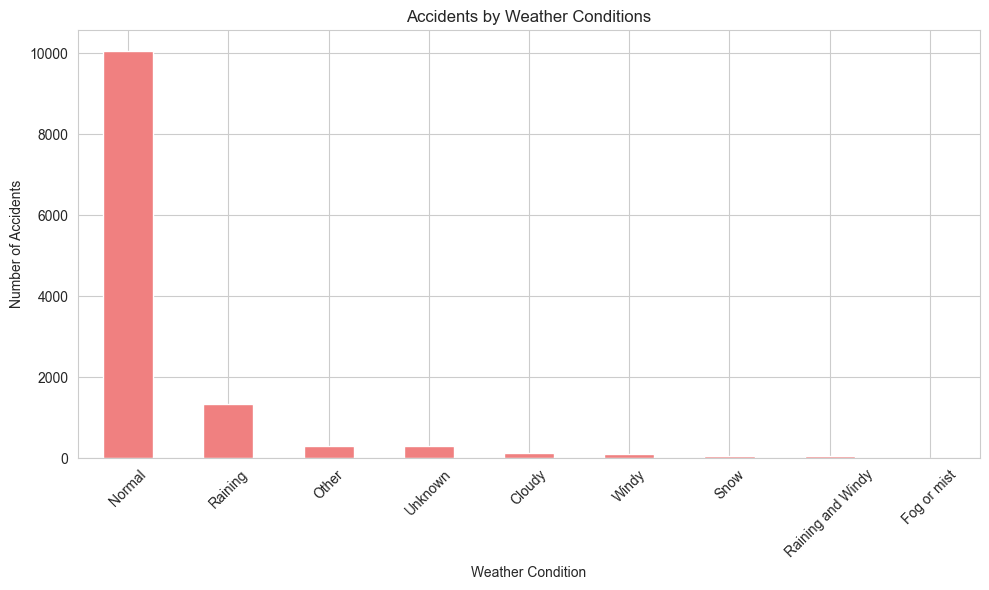

In [18]:
print("### Weather Conditions Impact")
weather_counts = df['Weather_conditions'].value_counts()
print(weather_counts)

plt.figure(figsize=(10, 6))
weather_counts.plot(kind='bar', color='lightcoral')
plt.xlabel('Weather Condition')
plt.ylabel('Number of Accidents')
plt.title('Accidents by Weather Conditions')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Road Surface Conditions


### Road Surface Conditions
Road_surface_conditions
Dry                     9340
Wet or damp             2904
Snow                      70
Flood over 3cm. deep       2
Name: count, dtype: int64


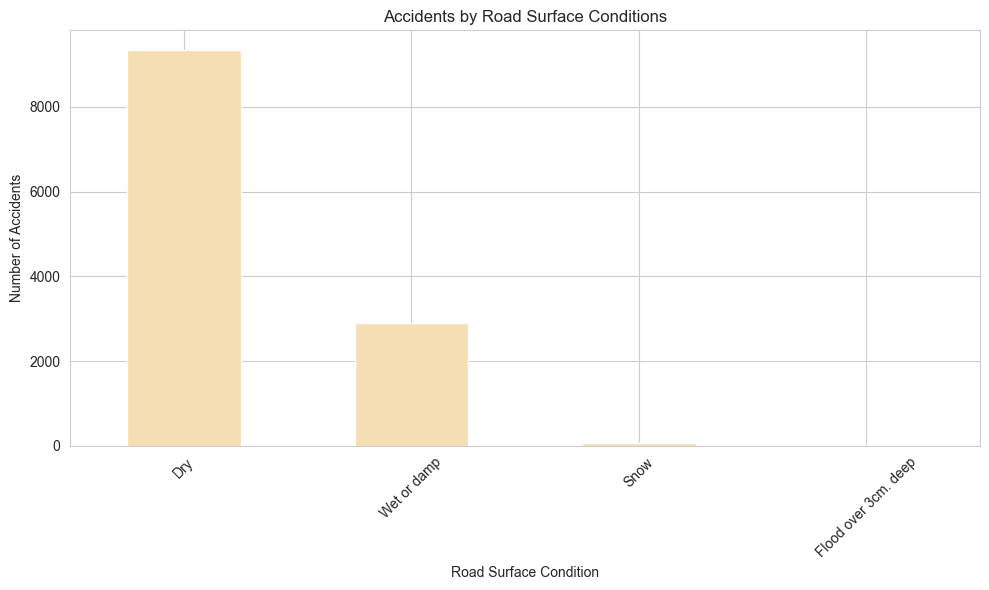

In [19]:
print("\n### Road Surface Conditions")
surface_counts = df['Road_surface_conditions'].value_counts()
print(surface_counts)

plt.figure(figsize=(10, 6))
surface_counts.plot(kind='bar', color='wheat')
plt.xlabel('Road Surface Condition')
plt.ylabel('Number of Accidents')
plt.title('Accidents by Road Surface Conditions')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Lighting Conditions


### Light Conditions
Light_conditions
Daylight                   8798
Darkness - lights lit      3286
Darkness - no lighting      192
Darkness - lights unlit      40
Name: count, dtype: int64


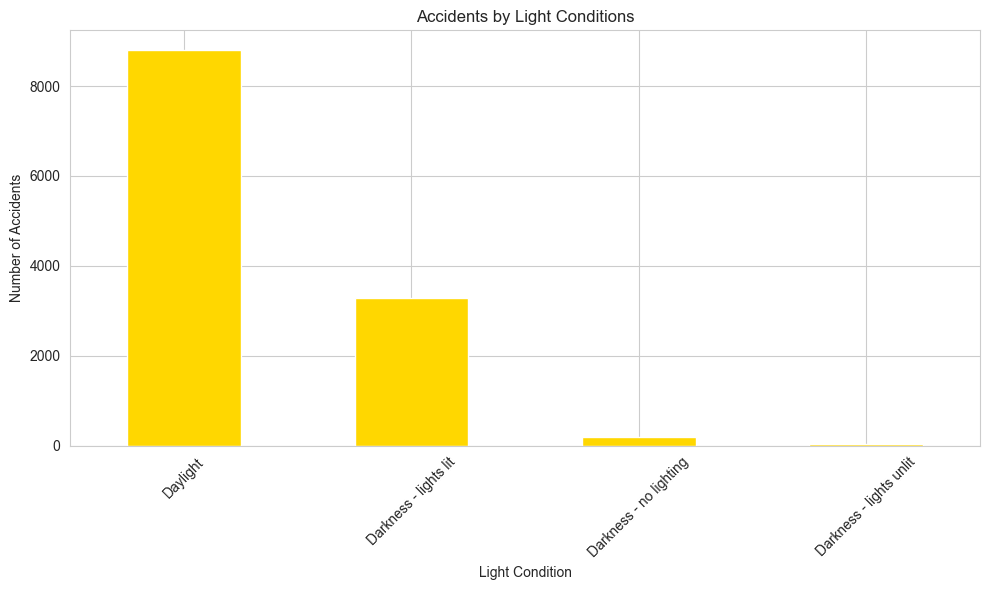

In [20]:
print("\n### Light Conditions")
light_counts = df['Light_conditions'].value_counts()
print(light_counts)

plt.figure(figsize=(10, 6))
light_counts.plot(kind='bar', color='gold')
plt.xlabel('Light Condition')
plt.ylabel('Number of Accidents')
plt.title('Accidents by Light Conditions')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Accident Severity Analysis

### Accident Severity Distribution
Accident_severity
Slight Injury     10415
Serious Injury     1743
Fatal injury        158
Name: count, dtype: int64

Percentages:
Accident_severity
Slight Injury     84.56
Serious Injury    14.15
Fatal injury       1.28
Name: count, dtype: float64


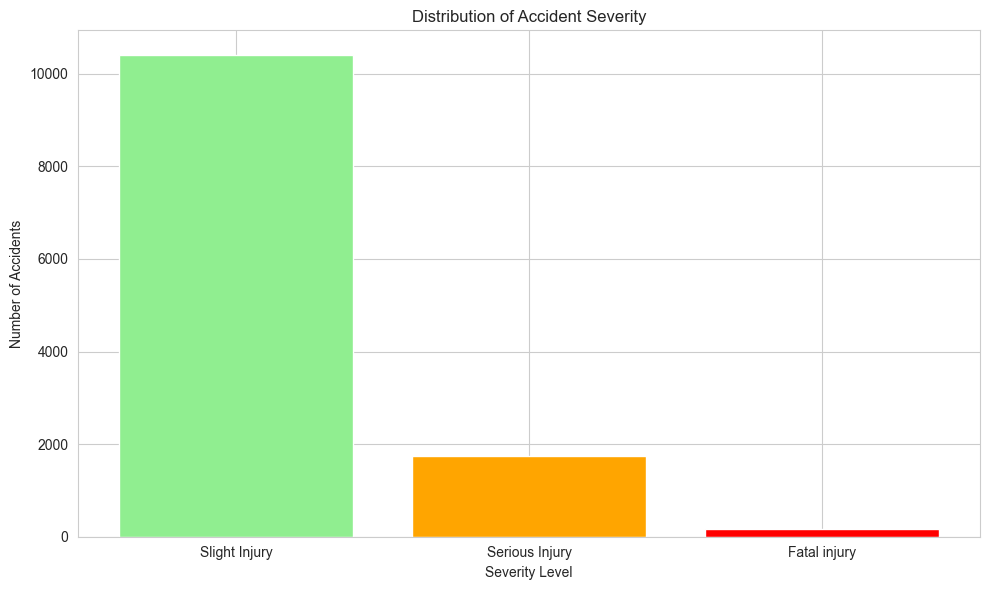

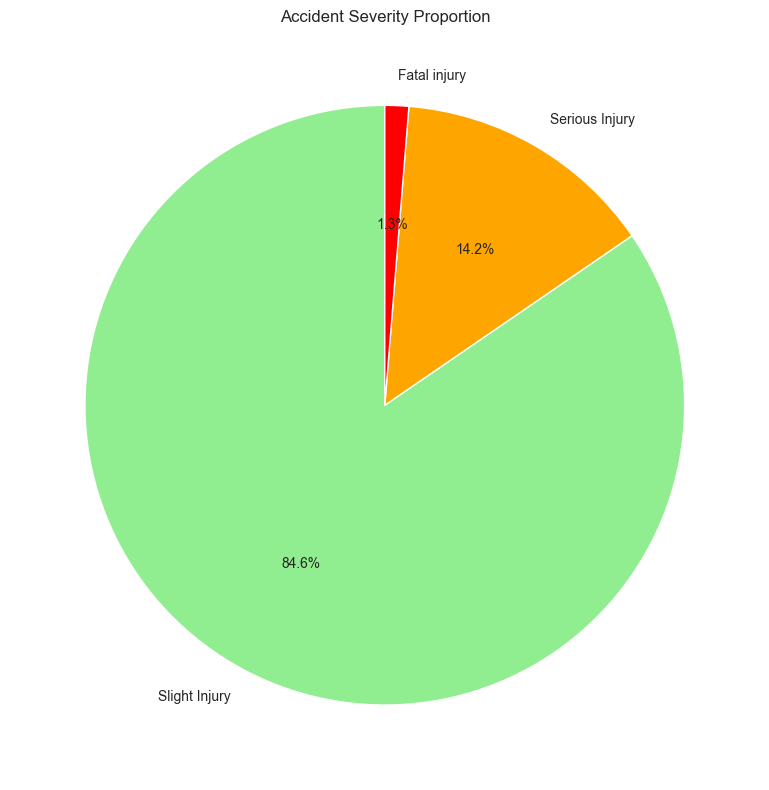

In [21]:
print("### Accident Severity Distribution")
severity_counts = df['Accident_severity'].value_counts()
print(severity_counts)
print(f"\nPercentages:")
print((severity_counts / len(df) * 100).round(2))

plt.figure(figsize=(10, 6))
colors = ['lightgreen', 'orange', 'red']
plt.bar(severity_counts.index, severity_counts.values, color=colors)
plt.xlabel('Severity Level')
plt.ylabel('Number of Accidents')
plt.title('Distribution of Accident Severity')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 8))
plt.pie(severity_counts.values, labels=severity_counts.index, autopct='%1.1f%%', 
        colors=colors, startangle=90)
plt.title('Accident Severity Proportion')
plt.tight_layout()
plt.show()

### Severity by Time of Day


### Severity by Hour of Day
Accident_severity  Fatal injury  Serious Injury  Slight Injury
Hour                                                          
0                             5              38            163
1                             4              17            113
2                             1              13             70
3                             6              22             56
4                             1               9             81
5                             0              20             56
6                             4              32            178
7                             1              77            454
8                             2             108            718
9                             6              78            475


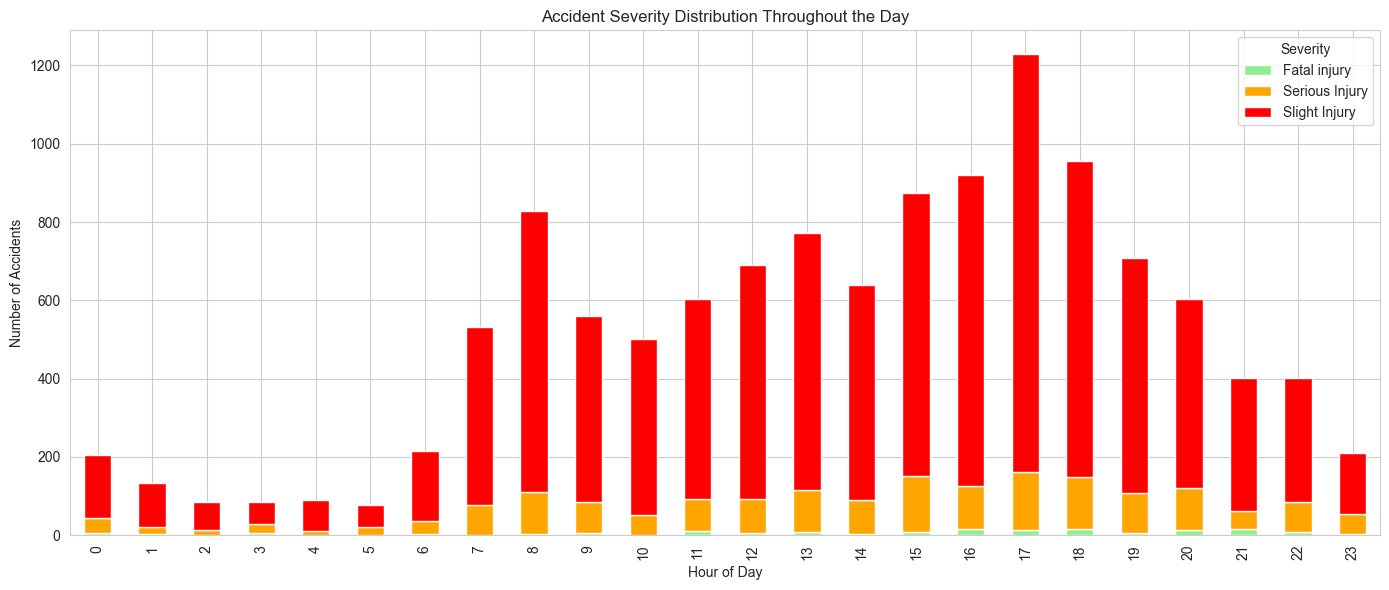

In [22]:
severity_hour = pd.crosstab(df['Hour'], df['Accident_severity'])
print("\n### Severity by Hour of Day")
print(severity_hour.head(10))

severity_hour.plot(kind='bar', stacked=True, figsize=(14, 6), 
                   color=['lightgreen', 'orange', 'red'])
plt.xlabel('Hour of Day')
plt.ylabel('Number of Accidents')
plt.title('Accident Severity Distribution Throughout the Day')
plt.legend(title='Severity')
plt.tight_layout()
plt.show()

### Common Causes of Accidents

### Top Causes of Accidents
Cause_of_accident
No distancing                           2263
Changing lane to the right              1808
Changing lane to the left               1473
Driving carelessly                      1402
No priority to vehicle                  1207
Moving Backward                         1137
No priority to pedestrian                721
Other                                    456
Overtaking                               430
Driving under the influence of drugs     340
Name: count, dtype: int64


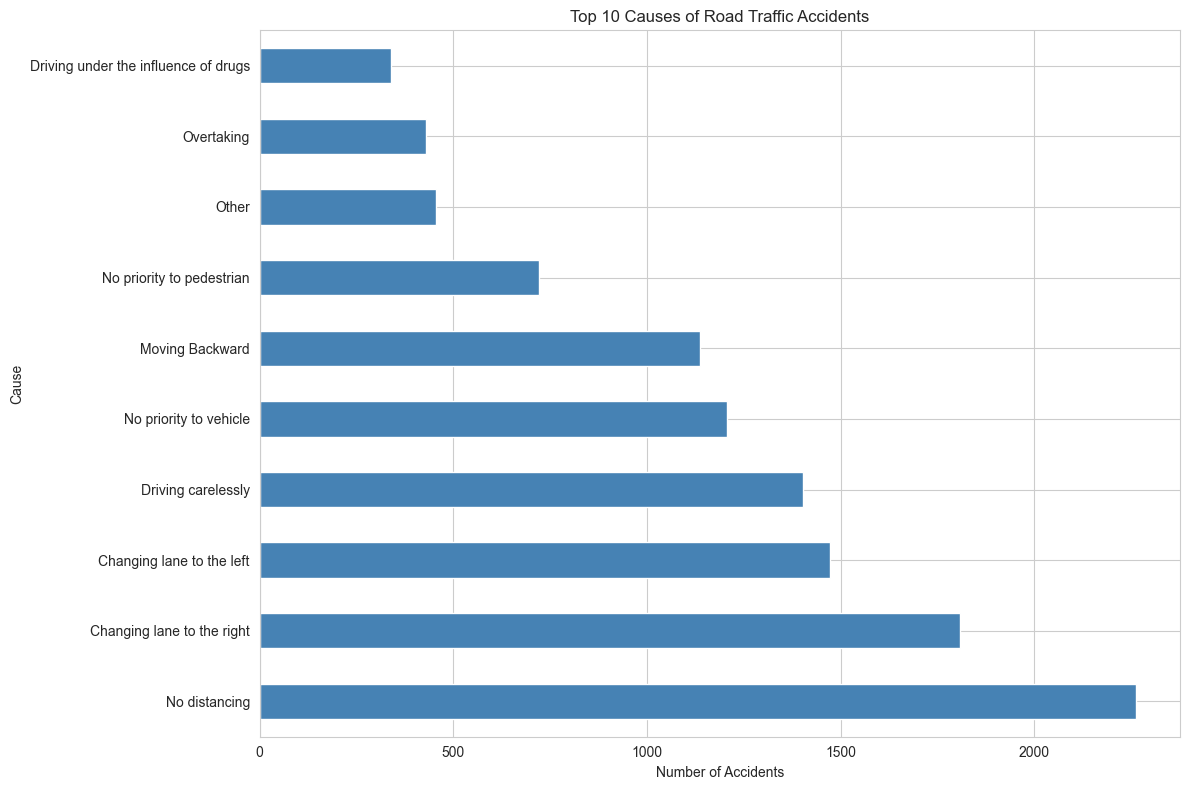

In [23]:
print("### Top Causes of Accidents")
cause_counts = df['Cause_of_accident'].value_counts().head(10)
print(cause_counts)

plt.figure(figsize=(12, 8))
cause_counts.plot(kind='barh', color='steelblue')
plt.xlabel('Number of Accidents')
plt.ylabel('Cause')
plt.title('Top 10 Causes of Road Traffic Accidents')
plt.tight_layout()
plt.show()

### Vehicle Type Involvement


### Vehicle Types Involved
Type_of_vehicle
Automobile              4155
Lorry (41?100Q)         2186
Other                   1208
Pick up upto 10Q         811
Public (12 seats)        711
Stationwagen             687
Lorry (11?40Q)           541
Public (13?45 seats)     532
Public (> 45 seats)      404
Long lorry               383
Name: count, dtype: int64


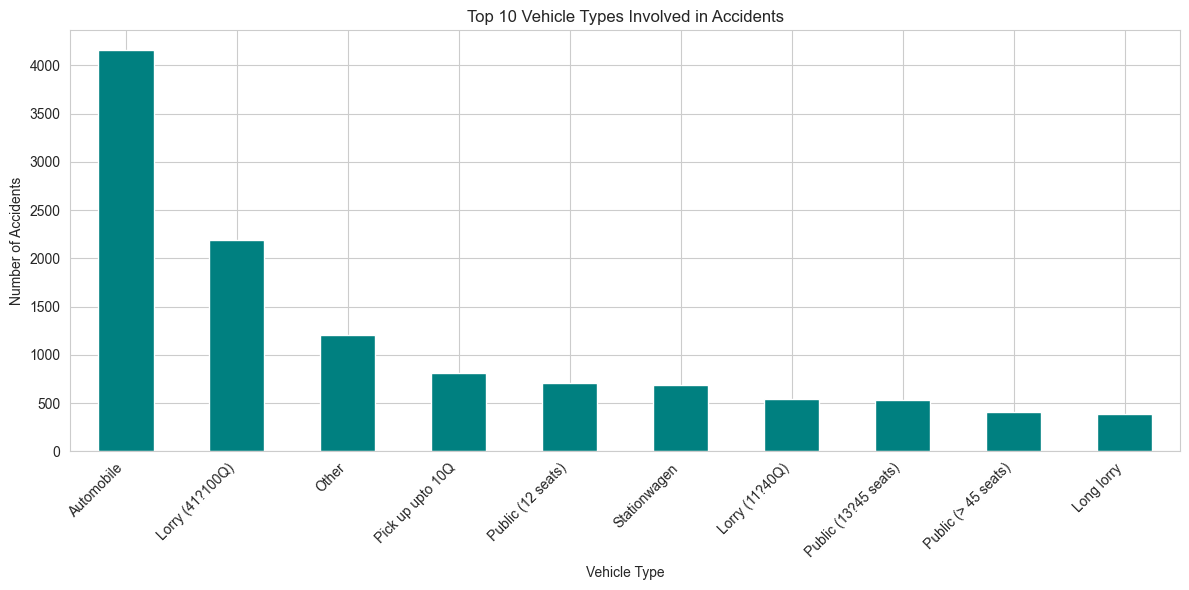

In [24]:
print("\n### Vehicle Types Involved")
vehicle_counts = df['Type_of_vehicle'].value_counts().head(10)
print(vehicle_counts)

plt.figure(figsize=(12, 6))
vehicle_counts.plot(kind='bar', color='teal')
plt.xlabel('Vehicle Type')
plt.ylabel('Number of Accidents')
plt.title('Top 10 Vehicle Types Involved in Accidents')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Collision Type Analysis


### Types of Collision
Type_of_collision
Vehicle with vehicle collision             8909
Collision with roadside objects            1786
Collision with pedestrians                  916
Rollover                                    397
Collision with animals                      171
Collision with roadside-parked vehicles      54
Fall from vehicles                           34
Other                                        26
Unknown                                      14
With Train                                    9
Name: count, dtype: int64


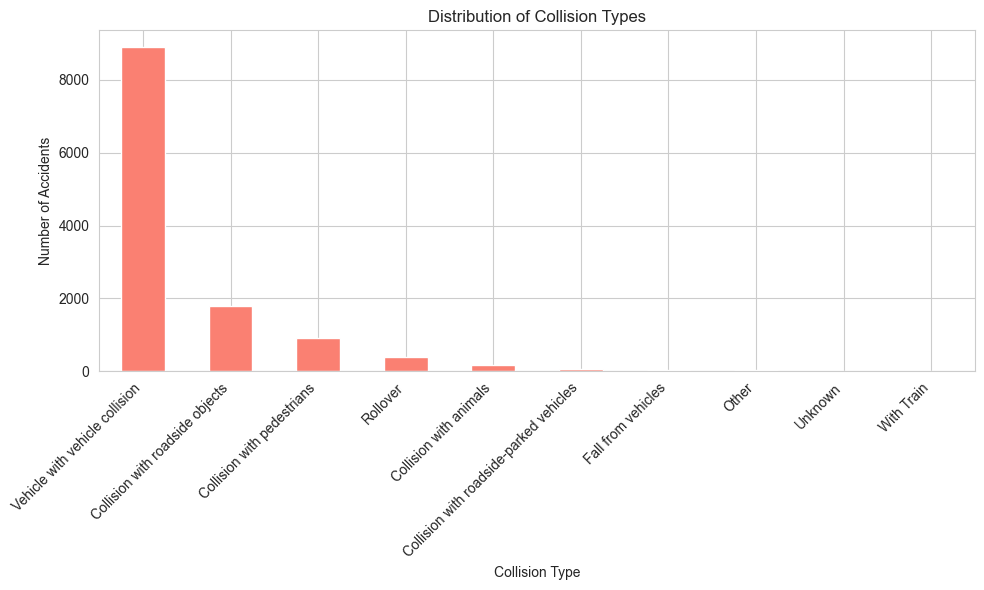

In [25]:
print("\n### Types of Collision")
collision_counts = df['Type_of_collision'].value_counts()
print(collision_counts)

plt.figure(figsize=(10, 6))
collision_counts.plot(kind='bar', color='salmon')
plt.xlabel('Collision Type')
plt.ylabel('Number of Accidents')
plt.title('Distribution of Collision Types')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Area Analysis


### Accident Areas
Area_accident_occured
Other                              3819
Office areas                       3632
Residential areas                  2118
 Church areas                      1060
 Industrial areas                   456
School areas                        415
  Recreational areas                327
 Outside rural areas                218
 Hospital areas                     121
  Market areas                       63
Rural village areas                  44
Unknown                              22
Rural village areasOffice areas      20
Recreational areas                    1
Name: count, dtype: int64


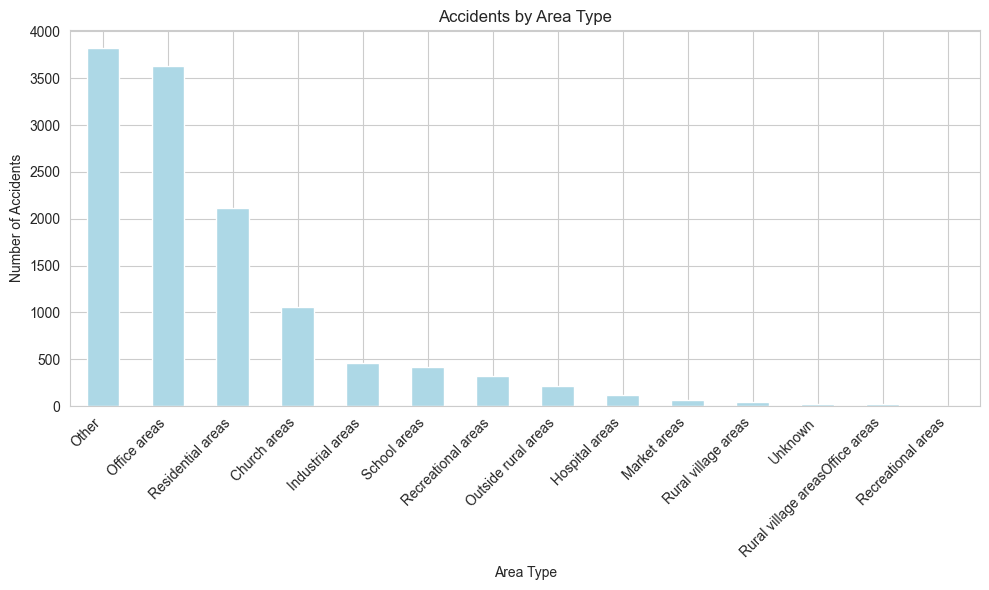

In [26]:
print("\n### Accident Areas")
area_counts = df['Area_accident_occured'].value_counts()
print(area_counts)

plt.figure(figsize=(10, 6))
area_counts.plot(kind='bar', color='lightblue')
plt.xlabel('Area Type')
plt.ylabel('Number of Accidents')
plt.title('Accidents by Area Type')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 4. Correlation Analysis

### Driver Age vs Accident Severity

### Driver Age Band vs Accident Severity
Accident_severity   Fatal injury  Serious Injury  Slight Injury
Age_band_of_driver                                             
18-30                       1.45           14.14          84.41
31-50                       1.32           13.24          85.44
Over 51                     1.51           16.21          82.27
Under 18                    1.45           20.48          78.06
Unknown                     0.39           11.11          88.50


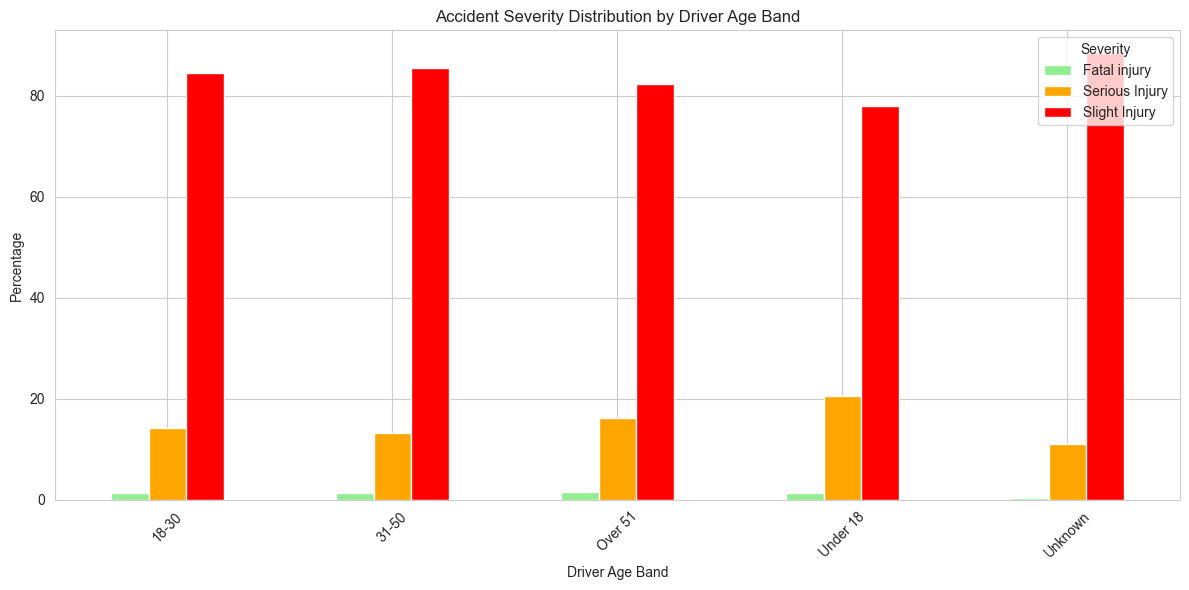

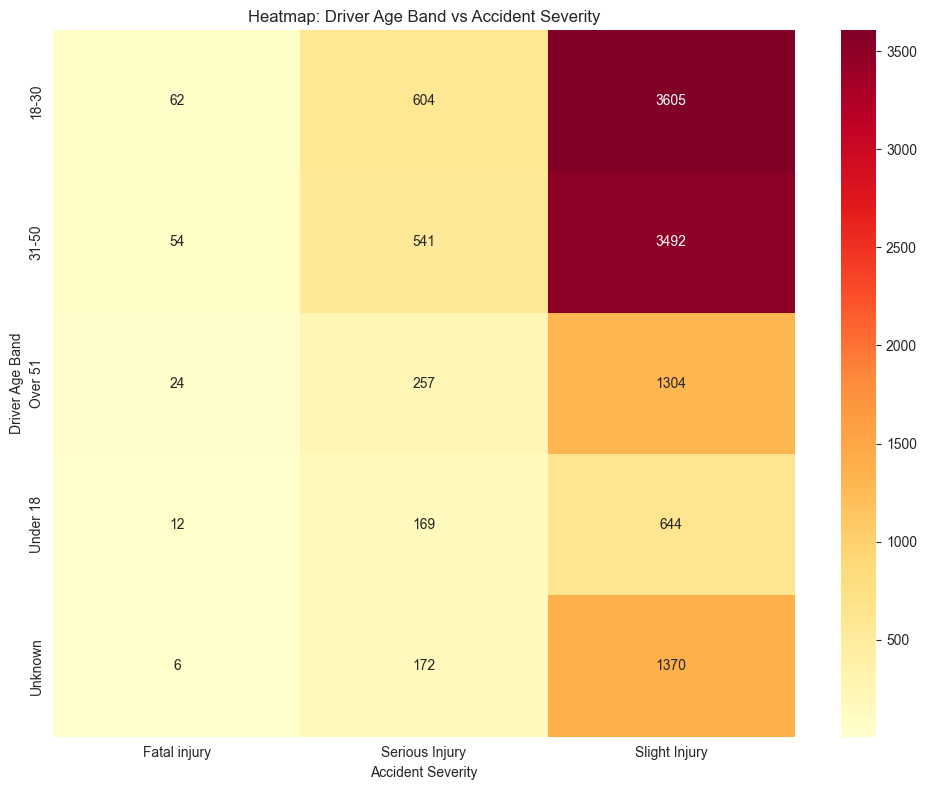

In [27]:
print("### Driver Age Band vs Accident Severity")
age_severity = pd.crosstab(df['Age_band_of_driver'], df['Accident_severity'], normalize='index') * 100
print(age_severity.round(2))

age_severity.plot(kind='bar', stacked=False, figsize=(12, 6), 
                  color=['lightgreen', 'orange', 'red'])
plt.xlabel('Driver Age Band')
plt.ylabel('Percentage')
plt.title('Accident Severity Distribution by Driver Age Band')
plt.legend(title='Severity')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 8))
age_severity_counts = pd.crosstab(df['Age_band_of_driver'], df['Accident_severity'])
sns.heatmap(age_severity_counts, annot=True, fmt='d', cmap='YlOrRd')
plt.xlabel('Accident Severity')
plt.ylabel('Driver Age Band')
plt.title('Heatmap: Driver Age Band vs Accident Severity')
plt.tight_layout()
plt.show()

### Casualty Age vs Severity


### Casualty Age Band vs Accident Severity
Accident_severity     Fatal injury  Serious Injury  Slight Injury
Age_band_of_casualty                                             
5                             1.23           18.03          80.74
18-30                         1.62           15.48          82.89
31-50                         1.10           14.22          84.68
Over 51                       1.61           12.37          86.02
Under 18                      1.26           12.17          86.57
na                            1.08           13.82          85.10


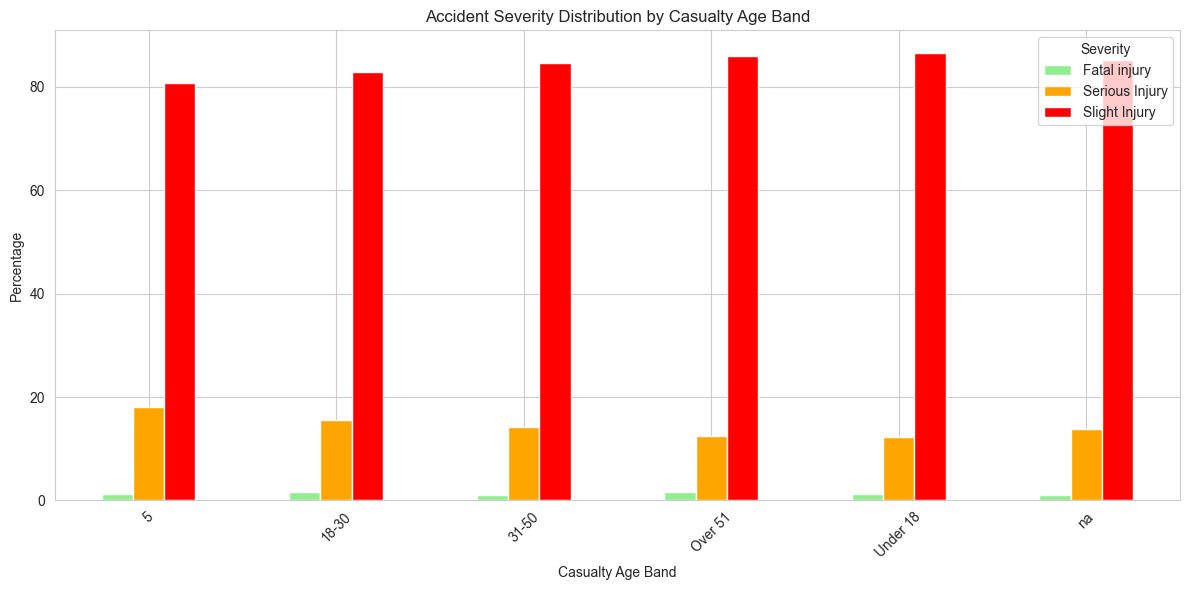

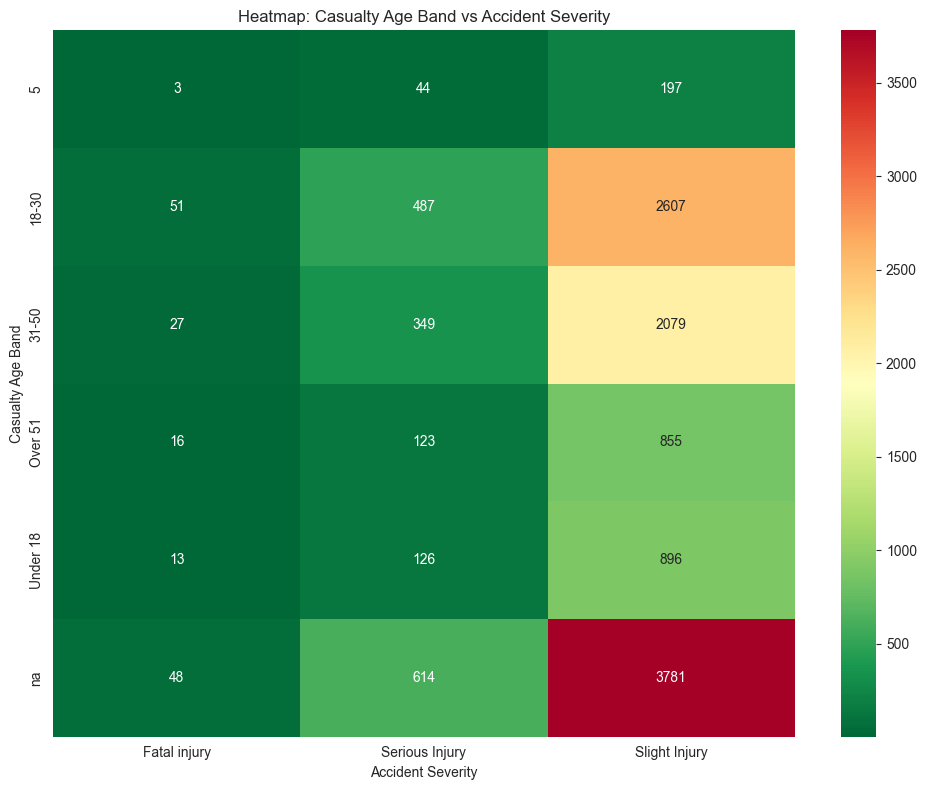

In [28]:
print("\n### Casualty Age Band vs Accident Severity")
casualty_severity = pd.crosstab(df['Age_band_of_casualty'], df['Accident_severity'], normalize='index') * 100
print(casualty_severity.round(2))

casualty_severity.plot(kind='bar', stacked=False, figsize=(12, 6),
                       color=['lightgreen', 'orange', 'red'])
plt.xlabel('Casualty Age Band')
plt.ylabel('Percentage')
plt.title('Accident Severity Distribution by Casualty Age Band')
plt.legend(title='Severity')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 8))
casualty_severity_counts = pd.crosstab(df['Age_band_of_casualty'], df['Accident_severity'])
sns.heatmap(casualty_severity_counts, annot=True, fmt='d', cmap='RdYlGn_r')
plt.xlabel('Accident Severity')
plt.ylabel('Casualty Age Band')
plt.title('Heatmap: Casualty Age Band vs Accident Severity')
plt.tight_layout()
plt.show()

### Experience vs Severity


### Driving Experience vs Accident Severity
Accident_severity   Fatal injury  Serious Injury  Slight Injury
Driving_experience                                             
1-2yr                       1.20           12.98          85.82
2-5yr                       1.79           14.75          83.46
5-10yr                      1.23           13.71          85.05
Above 10yr                  1.26           14.33          84.41
Below 1yr                   0.52           15.42          84.05
No Licence                  0.00           11.02          88.98
unknown                     3.03           18.18          78.79


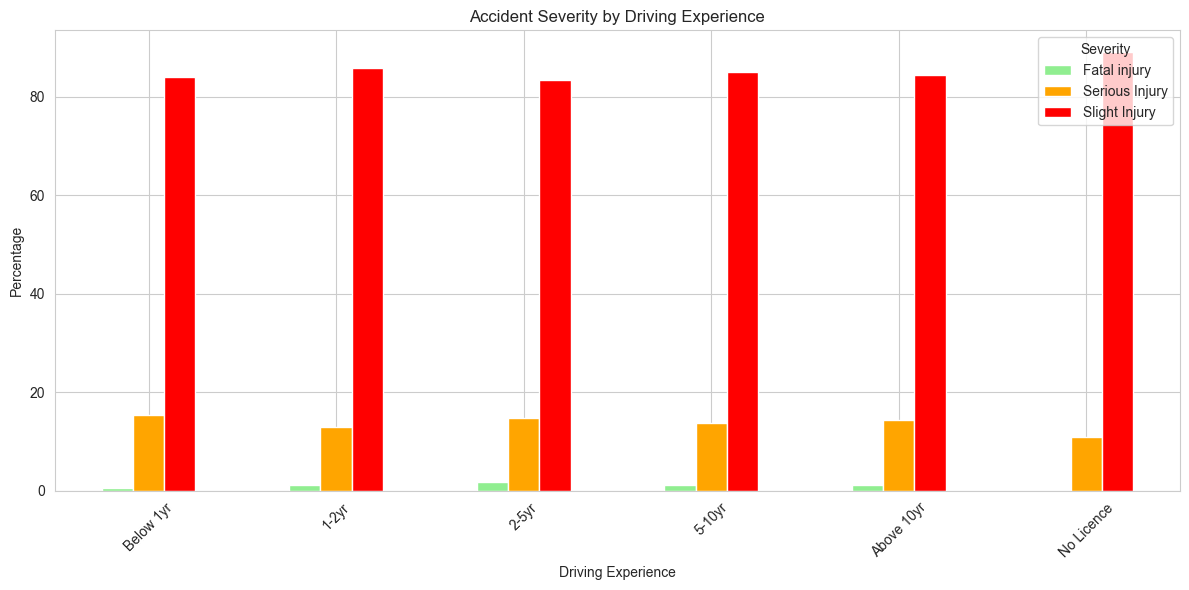

In [29]:
print("\n### Driving Experience vs Accident Severity")
exp_severity = pd.crosstab(df['Driving_experience'], df['Accident_severity'], normalize='index') * 100
print(exp_severity.round(2))

exp_order = ['Below 1yr', '1-2yr', '2-5yr', '5-10yr', 'Above 10yr', 'No Licence']
exp_severity_ordered = exp_severity.reindex([x for x in exp_order if x in exp_severity.index])

exp_severity_ordered.plot(kind='bar', stacked=False, figsize=(12, 6),
                          color=['lightgreen', 'orange', 'red'])
plt.xlabel('Driving Experience')
plt.ylabel('Percentage')
plt.title('Accident Severity by Driving Experience')
plt.legend(title='Severity')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Weather vs Severity


### Weather Conditions vs Accident Severity
Accident_severity   Fatal injury  Serious Injury  Slight Injury
Weather_conditions                                             
Cloudy                      0.00            6.40          93.60
Fog or mist                 0.00           10.00          90.00
Normal                      1.34           14.65          84.01
Other                       0.00            9.46          90.54
Raining                     1.73           11.87          86.40
Raining and Windy           0.00            5.00          95.00
Snow                        0.00            8.20          91.80
Unknown                     0.00           17.47          82.53
Windy                       0.00           16.33          83.67


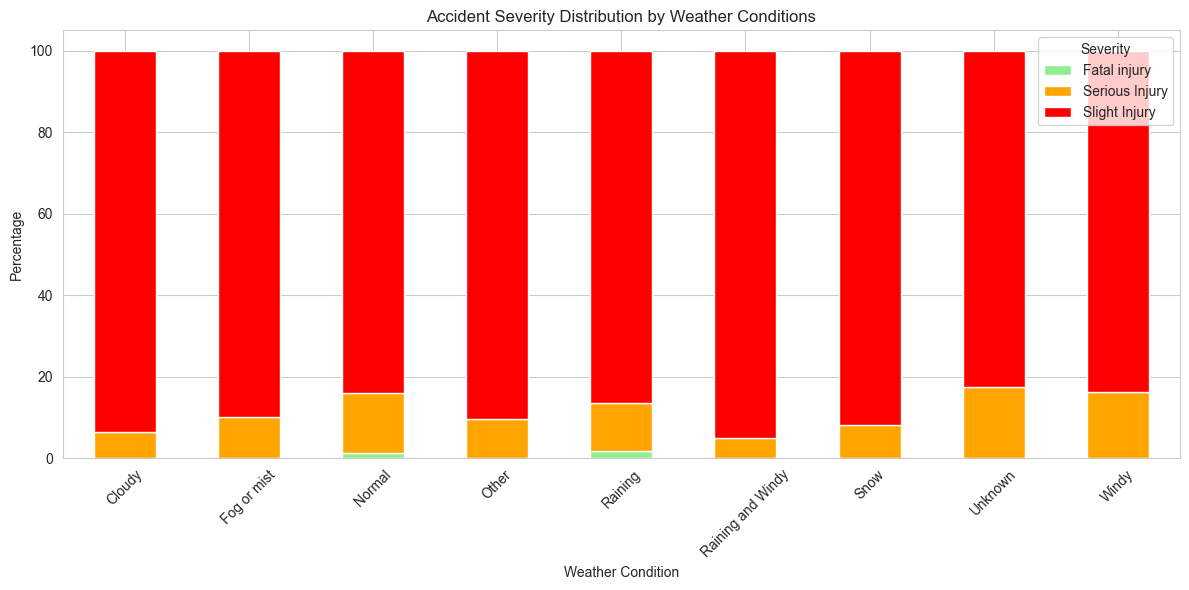

In [30]:
print("\n### Weather Conditions vs Accident Severity")
weather_severity = pd.crosstab(df['Weather_conditions'], df['Accident_severity'], normalize='index') * 100
print(weather_severity.round(2))

weather_severity.plot(kind='bar', stacked=True, figsize=(12, 6),
                      color=['lightgreen', 'orange', 'red'])
plt.xlabel('Weather Condition')
plt.ylabel('Percentage')
plt.title('Accident Severity Distribution by Weather Conditions')
plt.legend(title='Severity', loc='upper right')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Road Surface vs Severity


### Road Surface Conditions vs Accident Severity
Accident_severity        Fatal injury  Serious Injury  Slight Injury
Road_surface_conditions                                             
Dry                              1.30           14.26          84.44
Flood over 3cm. deep             0.00            0.00         100.00
Snow                             0.00            5.71          94.29
Wet or damp                      1.27           14.02          84.71


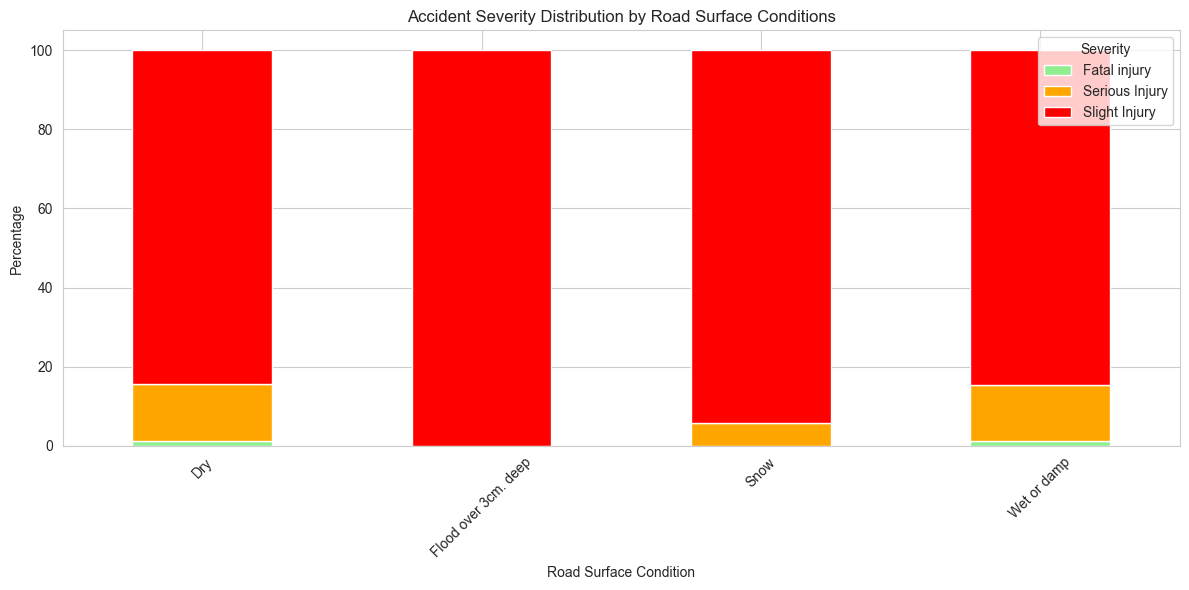

In [31]:
print("\n### Road Surface Conditions vs Accident Severity")
road_severity = pd.crosstab(df['Road_surface_conditions'], df['Accident_severity'], normalize='index') * 100
print(road_severity.round(2))

road_severity.plot(kind='bar', stacked=True, figsize=(12, 6),
                   color=['lightgreen', 'orange', 'red'])
plt.xlabel('Road Surface Condition')
plt.ylabel('Percentage')
plt.title('Accident Severity Distribution by Road Surface Conditions')
plt.legend(title='Severity', loc='upper right')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Light Conditions vs Severity


### Light Conditions vs Accident Severity
Accident_severity        Fatal injury  Serious Injury  Slight Injury
Light_conditions                                                    
Darkness - lights lit            2.01           14.15          83.84
Darkness - lights unlit          0.00           17.50          82.50
Darkness - no lighting           2.60           25.52          71.88
Daylight                         0.99           13.89          85.12


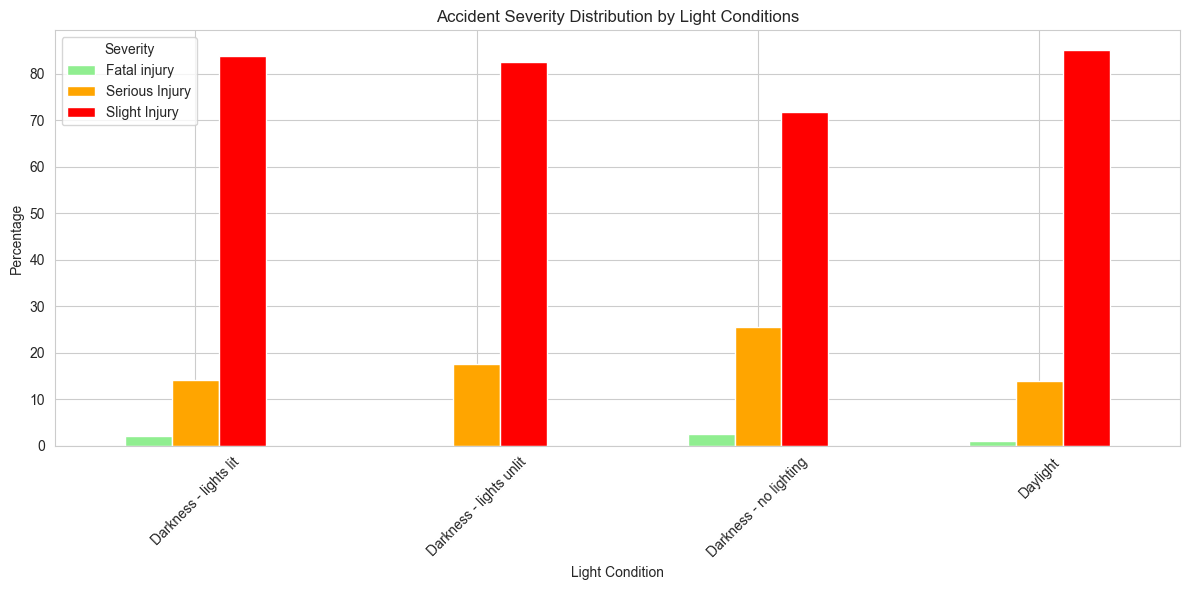

In [32]:
print("\n### Light Conditions vs Accident Severity")
light_severity = pd.crosstab(df['Light_conditions'], df['Accident_severity'], normalize='index') * 100
print(light_severity.round(2))

light_severity.plot(kind='bar', stacked=False, figsize=(12, 6),
                    color=['lightgreen', 'orange', 'red'])
plt.xlabel('Light Condition')
plt.ylabel('Percentage')
plt.title('Accident Severity Distribution by Light Conditions')
plt.legend(title='Severity')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 5. Key Insights Summary

In [33]:
print("=" * 80)
print("KEY FINDINGS SUMMARY")
print("=" * 80)

print("\n1. HIGH-RISK PERIODS:")
print(f"   - Peak accident hour: {df['Hour'].value_counts().idxmax()}:00")
print(f"   - Most accidents day: {df['Day_of_week'].value_counts().idxmax()}")

print("\n2. DRIVER DEMOGRAPHICS:")
print(f"   - Most affected age group: {df['Age_band_of_driver'].value_counts().idxmax()}")
print(f"   - Most common experience level: {df['Driving_experience'].value_counts().idxmax()}")
print(f"   - Gender distribution: Male {(df['Sex_of_driver'].value_counts()['Male']/len(df)*100):.1f}%")

print("\n3. ENVIRONMENTAL FACTORS:")
print(f"   - Most common weather: {df['Weather_conditions'].value_counts().idxmax()}")
print(f"   - Most common road surface: {df['Road_surface_conditions'].value_counts().idxmax()}")
print(f"   - Most common lighting: {df['Light_conditions'].value_counts().idxmax()}")

print("\n4. ACCIDENT CHARACTERISTICS:")
severity_dist = df['Accident_severity'].value_counts()
print(f"   - Slight injuries: {severity_dist['Slight Injury']} ({severity_dist['Slight Injury']/len(df)*100:.1f}%)")
print(f"   - Serious injuries: {severity_dist['Serious Injury']} ({severity_dist['Serious Injury']/len(df)*100:.1f}%)")
print(f"   - Fatal accidents: {severity_dist['Fatal injury']} ({severity_dist['Fatal injury']/len(df)*100:.1f}%)")

print(f"\n5. TOP CAUSES:")
top_causes = df['Cause_of_accident'].value_counts().head(3)
for i, (cause, count) in enumerate(top_causes.items(), 1):
    print(f"   {i}. {cause}: {count} ({count/len(df)*100:.1f}%)")

print("\n6. CORRELATION INSIGHTS:")
print(f"   - Young drivers (18-30) involved in {len(df[df['Age_band_of_driver']=='18-30'])} accidents")
fatal_young = len(df[(df['Age_band_of_driver']=='18-30') & (df['Accident_severity']=='Fatal injury')])
print(f"   - Fatal accidents in young drivers: {fatal_young}")
print(f"   - Inexperienced drivers (Below 1yr-2yr): {len(df[df['Driving_experience'].isin(['Below 1yr', '1-2yr'])])} accidents")

KEY FINDINGS SUMMARY

1. HIGH-RISK PERIODS:
   - Peak accident hour: 17:00
   - Most accidents day: Friday

2. DRIVER DEMOGRAPHICS:
   - Most affected age group: 18-30
   - Most common experience level: 5-10yr
   - Gender distribution: Male 92.9%

3. ENVIRONMENTAL FACTORS:
   - Most common weather: Normal
   - Most common road surface: Dry
   - Most common lighting: Daylight

4. ACCIDENT CHARACTERISTICS:
   - Slight injuries: 10415 (84.6%)
   - Serious injuries: 1743 (14.2%)
   - Fatal accidents: 158 (1.3%)

5. TOP CAUSES:
   1. No distancing: 2263 (18.4%)
   2. Changing lane to the right: 1808 (14.7%)
   3. Changing lane to the left: 1473 (12.0%)

6. CORRELATION INSIGHTS:
   - Young drivers (18-30) involved in 4271 accidents
   - Fatal accidents in young drivers: 62
   - Inexperienced drivers (Below 1yr-2yr): 3098 accidents


## 6. Save Cleaned Dataset

In [36]:
df.to_excel('RTA_Dataset_CLEANED.xlsx', index=False)
print("\n✓ Cleaned dataset saved as 'RTA_Dataset_CLEANED.xlsx'")
print(f"Final dataset shape: {df.shape}")
print(f"Missing values: {df.isnull().sum().sum()}")


✓ Cleaned dataset saved as 'RTA_Dataset_CLEANED.xlsx'
Final dataset shape: (12316, 28)
Missing values: 0


## 7. Statistical Summary

In [35]:
print("\n" + "=" * 80)
print("STATISTICAL SUMMARY")
print("=" * 80)

print(f"\nTotal accidents analyzed: {len(df):,}")
print(f"Total casualties: {df['Number_of_casualties'].sum():,}")
print(f"Average casualties per accident: {df['Number_of_casualties'].mean():.2f}")
print(f"Average vehicles involved: {df['Number_of_vehicles_involved'].mean():.2f}")

print("\nDataset completeness: 100%")
print(f"Variables analyzed: {len(df.columns)}")
print(f"Time period covered: {df['Day_of_week'].nunique()} days of the week")


STATISTICAL SUMMARY

Total accidents analyzed: 12,316
Total casualties: 19,067
Average casualties per accident: 1.55
Average vehicles involved: 2.04

Dataset completeness: 100%
Variables analyzed: 28
Time period covered: 7 days of the week
